# Problem 1 

## (a) 感知器OVO

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import copy

iris = datasets.load_iris()

In [ ]:
def Pocket(T : int,x,y) -> np.ndarray:
    if T == 0:
        T = 100000
    wt = np.zeros((len(x[0])+1,))
    w_pocket = np.zeros((len(x[0])+1,))
    error_pocket = len(x)
    if isinstance(x,np.ndarray):
        x = x.tolist()
    for xi in x:
        xi.append(1)
    x = np.array(x)
    y = np.array(y)
    for iter in range(T):
        predict = np.sign(wt.dot(x.T))
        miss_predict = np.absolute(predict - y)
        error_number = np.count_nonzero(miss_predict,axis=0)
        if error_number < error_pocket:
            w_pocket = wt
            error_pocket = error_number
            if error_pocket == 0:
                break
        n_iter = np.random.choice(np.flatnonzero(miss_predict))
        wt = wt + y[n_iter] * x[n_iter]
    return w_pocket


def gen_iris_data():
    X = iris.data
    Y = iris.target
    n = len(Y)
    permutation = np.random.permutation(n)
    X = X[permutation].tolist()
    Y = Y[permutation].tolist()
    X_train = [[],[],[]]
    Y_train = [[],[],[]]
    X_test = [[],[],[]]
    Y_test = [[],[],[]]
    cnt = [0,0,0]
    for i in range(n):
        if cnt[Y[i]] < 0.6 * (n // 3):
            X_train[Y[i]].append(X[i])
            Y_train[Y[i]].append(Y[i])
            cnt[Y[i]] += 1
        else:
            X_test[Y[i]].append(X[i])
            Y_test[Y[i]].append(Y[i])
    return (X_train,Y_train,X_test,Y_test)

def single_predict(w,x):
    if isinstance(x,np.ndarray):
        x = x.tolist()
    for xi in x:
        xi.append(1)    
    x = np.array(x)
    predict = np.sign(w.dot(x.T))
    return predict

def OVO_train_and_test(X_train,Y_train,X_test,Y_test):
    n_class = len(Y_train)
    n_test = len(Y_test[0])
    Ws = {}
    result = np.zeros((n_test * n_class,n_class))
    for i in range(n_class):
        for j in range(i + 1,n_class):
            X = copy.deepcopy(X_train[i])
            X.extend(copy.deepcopy(X_train[j]))
            Y = [1 for k in range(len(X_train[i]))]
            Y.extend([-1 for k in range(len(X_train[j]))])
            Ws[(i,j)] = Pocket(0,X,Y)
    for i,j in Ws.keys():
        X = copy.deepcopy(X_test[0])
        for k in range(1,n_class):
            X.extend(copy.deepcopy(X_test[k]))
        predict = single_predict(Ws[(i,j)],X)
        for k,res in zip(range(len(predict)),predict):
            if res == 1:
                result[k,i] += 1
            else:
                result[k,j] += 1
    expected_result = copy.deepcopy(Y_test[0])
    for i in range(1,n_class):
        expected_result.extend(Y_test[i])
    final_result = np.argmax(result,axis=1)
    print("We got : {}".format(final_result))
    print("Expected : {}".format(expected_result))
    miss_predict = np.absolute(final_result - expected_result)
    error_num = np.count_nonzero(miss_predict)
    total_num = len(expected_result) 
    print("Accuracy = " + str(1 - error_num / total_num))

X_train,Y_train,X_test,Y_test = gen_iris_data()
OVO_train_and_test(X_train,Y_train,X_test,Y_test)

We got : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Expected : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Accuracy = 0.9666666666666667


In [ ]:
OVO_train_and_test(X_train,Y_train,X_test,Y_test)

We got : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Expected : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Accuracy = 0.9666666666666667


可以看到，感知器OVO算法在Iris数据集上表现较好，在测试集上正确率接近100%。

## (b) Softmax多分类


In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

# 运行环境
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
print(device)

Tesla K80
cuda


In [20]:
from sklearn import datasets as ds

def gen_data():
    iris = ds.load_iris()
    X = iris.data.astype(np.float32)
    Y = iris.target
    X_train = np.concatenate((X[0:30,],X[70:100,],X[100:130,])).astype(np.float32)
    Y_train = np.concatenate((Y[0:30],Y[70:100],Y[100:130]))
    X_test = np.concatenate((X[30:50,],X[50:70,],X[130:150,])).astype(np.float32)
    Y_test = np.concatenate((Y[30:50],Y[50:70],Y[130:150]))
    return (Iris_Data_Set(X_train,Y_train),Iris_Data_Set(X_test,Y_test))

class Iris_Data_Set(Dataset):
    def __init__(self,X,Y,n = 3):
        self.X = X
        self.size = len(Y)
        # one hot encoding
        self.Y = np.zeros((len(Y),n)).astype(np.float32)
        for i in range(self.size):
            self.Y[i,Y[i]] += 1
        self.Y_ex = Y
    def __len__(self):
        return len(self.Y)
    def __getitem__(self,idx):
        return self.X[idx],self.Y[idx]

train_data,test_data = gen_data()
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [23]:
def train_single(data_loader,model,loss_fn,optimizer):
    total = len(data_loader.dataset)
    for batch,(X,Y) in enumerate(data_loader):
        # Forward
        predict = model(X)
        loss = loss_fn(predict,Y)
        # BP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print("{}/{}, loss = {}".format(batch * len(X),total,loss))
def test_single(data_loader,model,loss_fn,loss_arr,acc_arr):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X,Y in data_loader:
            predict = model(X)
            test_loss += loss_fn(predict, Y).item()
            correct += 1 if predict.argmax() == Y.argmax() else 0

    test_loss /= num_batches
    correct /= size
    loss_arr.append(test_loss)
    acc_arr.append(correct)
    print("test_loss = {},accuracy = {}".format(test_loss,correct))

In [24]:
# 超参数
learning_rate = 1e-2
epoch = 40

model = nn.Sequential(
        nn.Linear(4,3),
        nn.Softmax()
    )
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_arr = []
acc_arr = []
for i in range(epoch):
    print("epoch = {}".format(i))
    train_single(train_dataloader,model,loss_fn,optimizer)
    test_single(test_dataloader,model,loss_fn,loss_arr,acc_arr)

epoch = 0
0/90, loss = 1.0816322565078735
10/90, loss = 1.0661531686782837
20/90, loss = 1.0788041353225708
30/90, loss = 1.0891754627227783
40/90, loss = 1.035022497177124
50/90, loss = 1.053360104560852
60/90, loss = 1.074752688407898
70/90, loss = 1.0814707279205322
80/90, loss = 1.0760166645050049
test_loss = 1.0418529440959294,accuracy = 0.4666666666666667
epoch = 1
0/90, loss = 1.0257924795150757
10/90, loss = 1.0427554845809937
20/90, loss = 0.992375373840332
30/90, loss = 1.0501220226287842
40/90, loss = 1.0220489501953125
50/90, loss = 1.0393917560577393
60/90, loss = 1.002781629562378
70/90, loss = 0.9987131357192993
80/90, loss = 0.9941582679748535
test_loss = 0.9977941234906514,accuracy = 0.6666666666666666
epoch = 2
0/90, loss = 0.9252204895019531
10/90, loss = 0.9634884595870972
20/90, loss = 0.9296690225601196
30/90, loss = 0.9975457191467285
40/90, loss = 1.0374077558517456
50/90, loss = 1.0815693140029907
60/90, loss = 0.9947055578231812
70/90, loss = 0.899249255657196

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


test_loss = 0.89235234161218,accuracy = 0.6666666666666666
epoch = 6
0/90, loss = 0.9375094175338745
10/90, loss = 0.9868718385696411
20/90, loss = 0.8073518872261047
30/90, loss = 0.9086492657661438
40/90, loss = 0.792742908000946
50/90, loss = 0.9502599835395813
60/90, loss = 0.898582935333252
70/90, loss = 0.7996653914451599
80/90, loss = 0.8635374903678894
test_loss = 0.878744046886762,accuracy = 0.6666666666666666
epoch = 7
0/90, loss = 0.9517116546630859
10/90, loss = 0.8441257476806641
20/90, loss = 0.8585009574890137
30/90, loss = 0.9444824457168579
40/90, loss = 0.8822140693664551
50/90, loss = 0.8455023765563965
60/90, loss = 0.8239425420761108
70/90, loss = 0.9286645650863647
80/90, loss = 0.7623481154441833
test_loss = 0.8683658262093862,accuracy = 0.6666666666666666
epoch = 8
0/90, loss = 0.8056690096855164
10/90, loss = 0.8513954281806946
20/90, loss = 0.9691110849380493
30/90, loss = 0.8745579719543457
40/90, loss = 0.7363566160202026
50/90, loss = 0.9097080230712891
60/

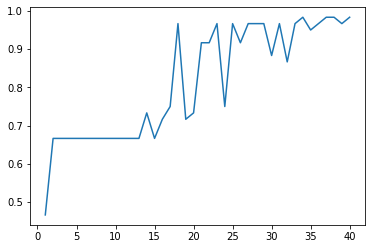

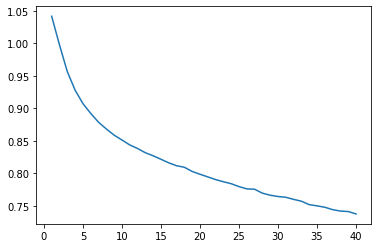

In [26]:
plt.plot(range(1,len(acc_arr)+1),acc_arr)
plt.show()
plt.plot(range(1,len(loss_arr)+1),loss_arr)
plt.show()

正确率与Loss的图像如图所示。可以看到，在loss下降的同时，acc在周期性波动的过程中上升。

# Problem 2

In [27]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
print(device)

Tesla K80
cuda


In [28]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



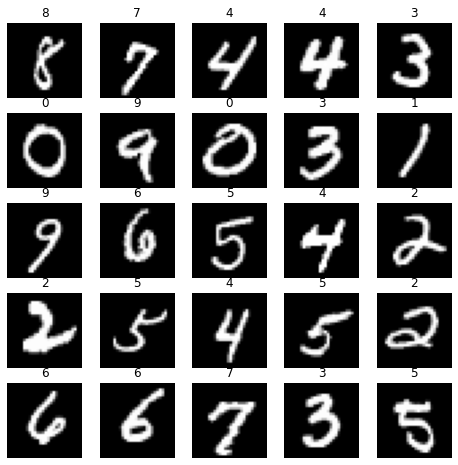

In [29]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [30]:
def train_single(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_single(dataloader,model,loss_fn,loss_arr,acc_arr,flag):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_arr.append(test_loss)
    acc_arr.append(correct)
    print(flag,end=' ')
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [31]:
# 超参数
batch_size = 256
total_epoch = 10
learning_rate = 1e-3

training_dataloader = DataLoader(training_data,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=256,shuffle=True)
train_v_dataloader = DataLoader(training_data,batch_size=256,shuffle=True)

In [35]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,10),
    nn.Softmax()
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(1,total_epoch+1):
    print("===== Epoch {} ======".format(i))
    train_single(training_dataloader,model,loss_fn,optimizer)
    test_single(test_dataloader,model,loss_fn,test_loss,test_acc,'Test')
    test_single(train_v_dataloader,model,loss_fn,train_loss,train_acc,'Train')

===== Epoch 1 ======
loss: 2.301689  [    0/60000]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 1.796868  [25600/60000]
loss: 1.676600  [51200/60000]
Test Test Error: 
 Accuracy: 87.5%, Avg loss: 1.661345 

Train Test Error: 
 Accuracy: 86.9%, Avg loss: 1.668908 

===== Epoch 2 ======
loss: 1.613602  [    0/60000]
loss: 1.632959  [25600/60000]
loss: 1.623418  [51200/60000]
Test Test Error: 
 Accuracy: 90.0%, Avg loss: 1.608088 

Train Test Error: 
 Accuracy: 89.3%, Avg loss: 1.615776 

===== Epoch 3 ======
loss: 1.594058  [    0/60000]
loss: 1.620434  [25600/60000]
loss: 1.610312  [51200/60000]
Test Test Error: 
 Accuracy: 90.7%, Avg loss: 1.587774 

Train Test Error: 
 Accuracy: 90.2%, Avg loss: 1.594226 

===== Epoch 4 ======
loss: 1.606213  [    0/60000]
loss: 1.602104  [25600/60000]
loss: 1.585765  [51200/60000]
Test Test Error: 
 Accuracy: 91.1%, Avg loss: 1.576093 

Train Test Error: 
 Accuracy: 90.8%, Avg loss: 1.582155 

===== Epoch 5 ======
loss: 1.583296  [    0/60000]
loss: 1.574822  [25600/60000]
loss: 1.579816  [51200/60000]
Test Test Error: 
 Accuracy: 91.5%, 

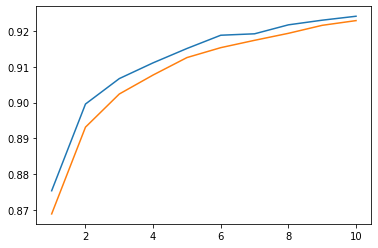

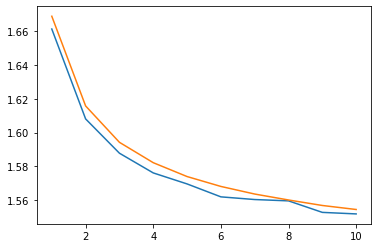

In [36]:
plt.plot(range(1,11),test_acc)
plt.plot(range(1,11),train_acc)
plt.show()
plt.plot(range(1,11),test_loss)
plt.plot(range(1,11),train_loss)
plt.show()

我们可以看到，随着训练的进行，loss降低的同时acc升高，训练结果良好。

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


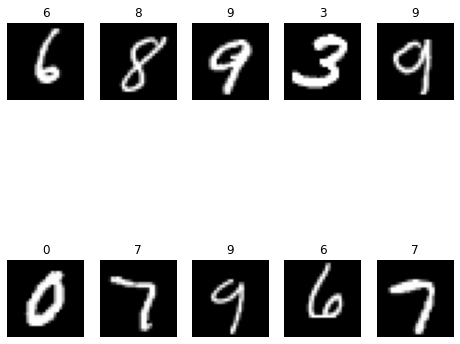

In [37]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    #img, label = training_data[sample_idx]
    sample = next(iter(train_v_dataloader))
    img,label = sample
    figure.add_subplot(rows, cols, i)
    predict = model.forward(img).argmax(1)
    if predict[i] == label[i]:
        plt.title("{}".format(label[i]))
    else:
        plt.title("output={},expect={}".format(predict[i],label[i]))
    plt.axis("off")
    plt.imshow(img[i].squeeze(), cmap="gray")
plt.show()

随机抽取十个数字，全部识别正确。